## python勉強会　第17回opencv2

In [1]:
import cv2
from skimage import io
import numpy as np 
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd 
%matplotlib inline


Bad key "font..family" on line 199 in
C:\Users\user\.matplotlib\matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### 参考URL
#### http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html#py-table-of-content-imgproc
#### https://datawokagaku.com/opencv/

### 問題１：左の画像を読み込んでください。さらに、読み込んだ画像を平滑化（ぼか）してください。
#### cv2.blurを使います。
![](./opencv2/water_coins.jpg)
![](./opencv2/blur.jpg)

True

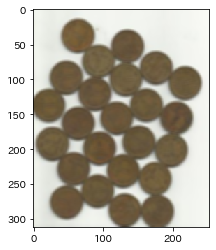

In [2]:
#答え
img = io.imread("./opencv2/water_coins.jpg")
blur_img = cv2.blur(img,(5,5))

plt.imshow(blur_img)

blur_img = cv2.cvtColor(blur_img,cv2.COLOR_RGB2BGR)
cv2.imwrite("./opencv2/blur.jpg",blur_img)

### 問題２：読み込んだ画像をコインが白、背景が黒になるようにしてください。さらにその画像に、オープニング、クロージング処理をしてください。
#### cv2.morphologyExを使います。
![](./opencv2/bitwise.jpg)
![](./opencv2/opening.jpg)
![](./opencv2/closing.jpg)

In [3]:
#答え
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret,binary_img = cv2.threshold(gray,150,255,cv2.THRESH_BINARY)
bitwise_img = cv2.bitwise_not(binary_img)

kernel = np.ones((5,5))
opening_img = cv2.morphologyEx(bitwise_img, cv2.MORPH_OPEN, kernel)
closing_img = cv2.morphologyEx(bitwise_img, cv2.MORPH_CLOSE, kernel)

cv2.imwrite("./opencv2/bitwise.jpg",bitwise_img)
cv2.imwrite("./opencv2/opening.jpg",opening_img)
cv2.imwrite("./opencv2/closing.jpg",closing_img)


True

### 問題３：コインが白色の画像に距離変換をかけて、白領域を分離してください。さらにその画像に粒子解析を実行し、各粒子の重心座標に赤丸を入れてください。
#### 距離変換：cv2.distanceTransform,粒子解析：cv2.connectedComponentsWithStats,赤丸：cv2.circleを使います。
#### 注）numpyの座標指定を使います。cv2.connectedComponentsWithStatsで返されるデータ形状をよく見てください。
#### https://qiita.com/ysdyt/items/5972c9520acf6a094d90
![](./opencv2/sure_fg.jpg)
![](./opencv2/return_img.jpg)

True

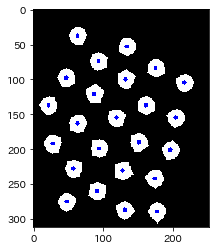

In [24]:
#答え
#距離を出す。
dist_transform = cv2.distanceTransform(bitwise_img,cv2.DIST_L2,5)
#絶対の前景を出す。
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

plt.imshow(sure_fg)

nLabels, labelImages, datas, centroids = cv2.connectedComponentsWithStats(sure_fg)
        
#同じサイズの画像を作成する。
return_img = np.zeros((sure_fg.shape[0],sure_fg.shape[1],3),dtype=np.uint8)

for index in range(nLabels):
    if not index == 0:
        return_img[labelImages==index] = (255,255,255)
        center_x,center_y = centroids[index,:]
        #return_img[int(center_y),int(center_x)] = (255,0,0)
        return_img = cv2.circle(return_img,(int(center_x),int(center_y)), 3, (0,0,255), -1)

plt.imshow(return_img)

cv2.imwrite("./opencv2/sure_fg.jpg",sure_fg)
cv2.imwrite("./opencv2/return_img.jpg",return_img)

### 問題４：各粒子の情報（面積、重心座標）を整理してエクセルで保存してください。
#### cv2.connectedComponentsWithStatsで得られたデータ、pandasを使います。

In [48]:
#答え
nLabels, labelImages, datas, centroids

save_data = np.hstack((datas,centroids))

save_df = pd.DataFrame(save_data,columns=["left_x","left_y","width","height","area","center_x","center_y"])
save_df.to_csv("./opencv2/save_csv.csv")

### 問題５：分水嶺アルゴリズムを適用し、コインを個別に分離してください。各コインの色を別々に指定して表示してください。（文字は入れなくても大丈夫です。）
#### https://qiita.com/ysdyt/items/5972c9520acf6a094d90
![](./opencv2/water_threshold.jpg)

In [51]:
#答え
# モルフォロジー演算のDilationを使う
kernel = np.ones((3,3),np.uint8)
sure_bg = cv2.dilate(bitwise_img,kernel,iterations=2)

#距離を出す。
dist_transform = cv2.distanceTransform(bitwise_img,cv2.DIST_L2,5)

#絶対の前景を出す。
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

#背景か前景かわからない部分を出す。
unknown = cv2.subtract(sure_bg,sure_fg)

#確実な前景において、粒子ラベリングする。
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1

#背景か前景かわからない領域を0にする。
markers[unknown==255] = 0

# "ヒント"であるmarkersをwatershedに適応する
markers = cv2.watershed(img,markers)

#カラー画像のコピーを作成する。
image_copy = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)

for marker in np.unique(markers):
    if marker >= 2:
        r = np.random.randint(0,255)
        g = np.random.randint(0,255)
        b = np.random.randint(0,255)
        tmp = markers==marker
        image_copy[tmp] = (r,g,b)

        #重心座標を出す。
        mu = cv2.moments(np.uint8(tmp*255))
        x,y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
        
        cv2.putText(image_copy, str(marker-1), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)    

cv2.imwrite("./opencv2/water_threshold.jpg",image_copy)

True